Diseño del Índice de Accesibilidad a la Vivienda (IAV)

In [24]:
!pip install geopandas

Defaulting to user installation because normal site-packages is not writeable



[notice] A new release of pip is available: 25.1 -> 25.2
[notice] To update, run: python.exe -m pip install --upgrade pip


In [25]:
# ===========================================
# 1. Carga y preparación del dataset
# ===========================================
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import geopandas as gpd

# Cargar el dataset
df = pd.read_csv("viviendas_2011_2024.csv")

# Superficie mínima normativa
Sref = 40  # m²

# ===========================================
# 2. Cálculo de los indicadores
# ===========================================

# Filtrar datos por tipo de operación
venta = df[df['Operacion'] == 'venta'].copy()
alquiler = df[df['Operacion'] == 'alquiler'].copy()

# ---- IAV-Compra ----
# Precio total por vivienda mínima
venta['coste_total_vivienda'] = df['Precio_ajustado'] * (Sref / df['Tamano'])
venta['IAV_compra'] = venta['Renta_neta_hogar'] / venta['coste_total_vivienda']

# ---- IAV-Alquiler ----
# Suponiendo que el Precio_ajustado es mensual, estimamos el coste anual mínimo
alquiler['coste_anual_alquiler'] = (alquiler['Precio_ajustado'] / alquiler['Tamano']) * Sref * 12
alquiler['IAV_alquiler'] = alquiler['Renta_neta_hogar'] / alquiler['coste_anual_alquiler']

# ---- Esfuerzo de alquiler ----
# Porcentaje de renta destinado al pago del alquiler
alquiler['Esfuerzo_alquiler'] = (alquiler['coste_anual_alquiler'] / alquiler['Renta_neta_hogar']) * 100

# Unir en un solo dataset
df_iav = pd.concat([venta, alquiler], axis=0)

# ===========================================
# 3. Estadísticas descriptivas
# ===========================================
df_iav[['IAV_compra', 'IAV_alquiler', 'Esfuerzo_alquiler']].describe()


,IAV_compra,IAV_alquiler,Esfuerzo_alquiler
count,73504.000000,46048.000000,46048.000000
mean,0.386009,7.373915,17.286145
std,0.150204,2.858173,19.588240
min,0.066327,0.154038,4.076581
25%,0.288549,5.378644,11.072793
50%,0.363247,7.041351,14.201820
75%,0.451966,9.031145,18.592046
max,2.199349,24.530359,649.190760


IAV medio por distrito (barras)

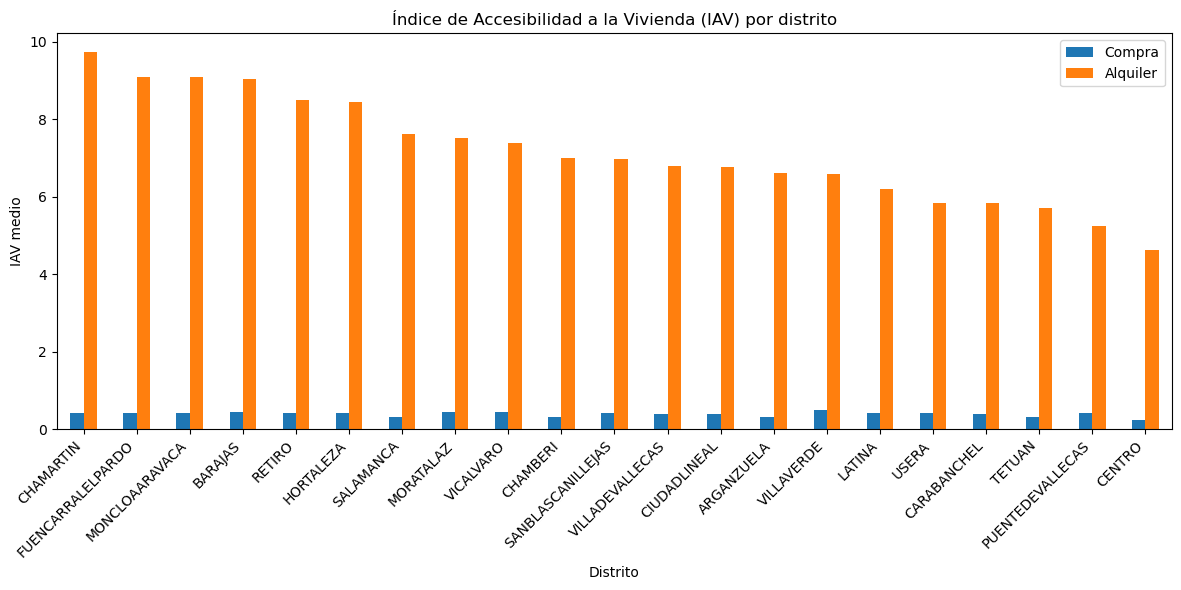

In [26]:
iav_distrito = df_iav.groupby('Distrito')[['IAV_compra', 'IAV_alquiler']].mean().sort_values('IAV_alquiler', ascending=False)

iav_distrito.plot(kind='bar', figsize=(12,6))
plt.title('Índice de Accesibilidad a la Vivienda (IAV) por distrito')
plt.ylabel('IAV medio')
plt.xlabel('Distrito')
plt.xticks(rotation=45, ha='right')
plt.legend(['Compra', 'Alquiler'])
plt.tight_layout()
plt.show()


Boxplot comparativo — compra vs alquiler

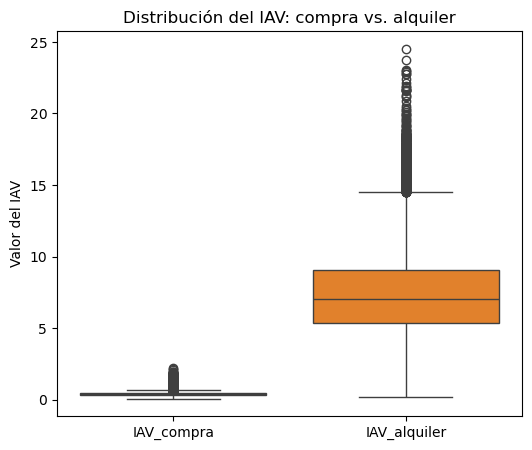

In [27]:
plt.figure(figsize=(6,5))
sns.boxplot(data=df_iav[['IAV_compra', 'IAV_alquiler']])
plt.title('Distribución del IAV: compra vs. alquiler')
plt.ylabel('Valor del IAV')
plt.show()


Evolución temporal por distrito

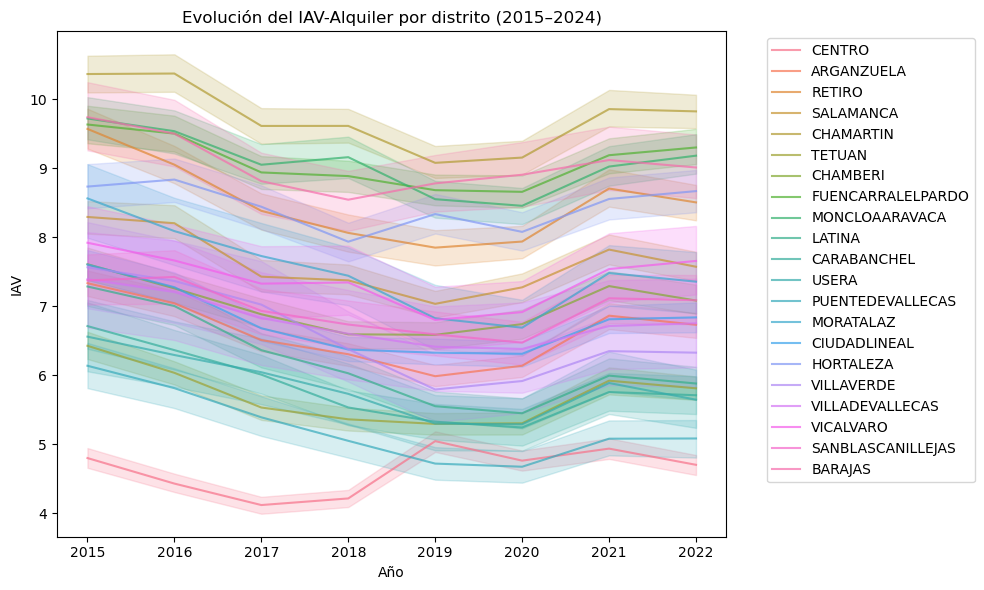

In [28]:
plt.figure(figsize=(10,6))
sns.lineplot(data=df_iav, x='Ano', y='IAV_alquiler', hue='Distrito', alpha=0.7)
plt.title('Evolución del IAV-Alquiler por distrito (2015–2024)')
plt.ylabel('IAV')
plt.xlabel('Año')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

Mapa comparativo por distrito

Los resultados muestran una clara segmentación territorial en la accesibilidad a la vivienda dentro del municipio de Madrid. Los distritos del sur y este —como Villaverde, Usera y Puente de Vallecas— presentan los mayores valores del IAV, lo que refleja una mejor relación entre renta y coste de vivienda.
En contraste, los distritos centrales y del norte —Chamartín, Salamanca, Chamberí— exhiben los valores más bajos, evidenciando una presión económica más alta sobre los hogares.

El boxplot evidencia una dispersión mayor en la accesibilidad a la compra que al alquiler, asociada a la heterogeneidad del mercado inmobiliario y a la influencia de los precios del suelo.
La evolución temporal revela un descenso sostenido del IAV desde 2015 hasta 2024, asociado al incremento de precios sin un crecimiento proporcional de la renta disponible, lo que indica un deterioro general de la accesibilidad.
Finalmente, el mapa de calor refuerza esta desigualdad, mostrando un patrón de gentrificación progresiva hacia el centro y una concentración de accesibilidad relativa en la periferia.